In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
pip install pandas numpy tensorflow matplotlib


In [ ]:
from tensorflow.keras.layers import LSTM, Dense


In [ ]:
data = pd.read_csv('owid-co2-data.csv')

In [ ]:
print("First few rows of the dataset:")
print(data.head())


First few rows of the dataset:
       country  year iso_code  population  gdp  cement_co2  \
0  Afghanistan  1850      AFG   3752993.0  NaN         NaN   
1  Afghanistan  1851      AFG   3767956.0  NaN         NaN   
2  Afghanistan  1852      AFG   3783940.0  NaN         NaN   
3  Afghanistan  1853      AFG   3800954.0  NaN         NaN   
4  Afghanistan  1854      AFG   3818038.0  NaN         NaN   

   cement_co2_per_capita  co2  co2_growth_abs  co2_growth_prct  ...  \
0                    NaN  NaN             NaN              NaN  ...   
1                    NaN  NaN             NaN              NaN  ...   
2                    NaN  NaN             NaN              NaN  ...   
3                    NaN  NaN             NaN              NaN  ...   
4                    NaN  NaN             NaN              NaN  ...   

   share_global_other_co2  share_of_temperature_change_from_ghg  \
0                     NaN                                   NaN   
1                     NaN          

In [ ]:
print("\nBasic Information about the dataset:")
print(data.info())


Basic Information about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47415 entries, 0 to 47414
Data columns (total 79 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   country                                    47415 non-null  object 
 1   year                                       47415 non-null  int64  
 2   iso_code                                   39548 non-null  object 
 3   population                                 39414 non-null  float64
 4   gdp                                        15211 non-null  float64
 5   cement_co2                                 23764 non-null  float64
 6   cement_co2_per_capita                      22017 non-null  float64
 7   co2                                        30308 non-null  float64
 8   co2_growth_abs                             28157 non-null  float64
 9   co2_growth_prct                            24684 non-nul

In [ ]:
data['year'] = pd.to_datetime(data['year'], format='%Y')


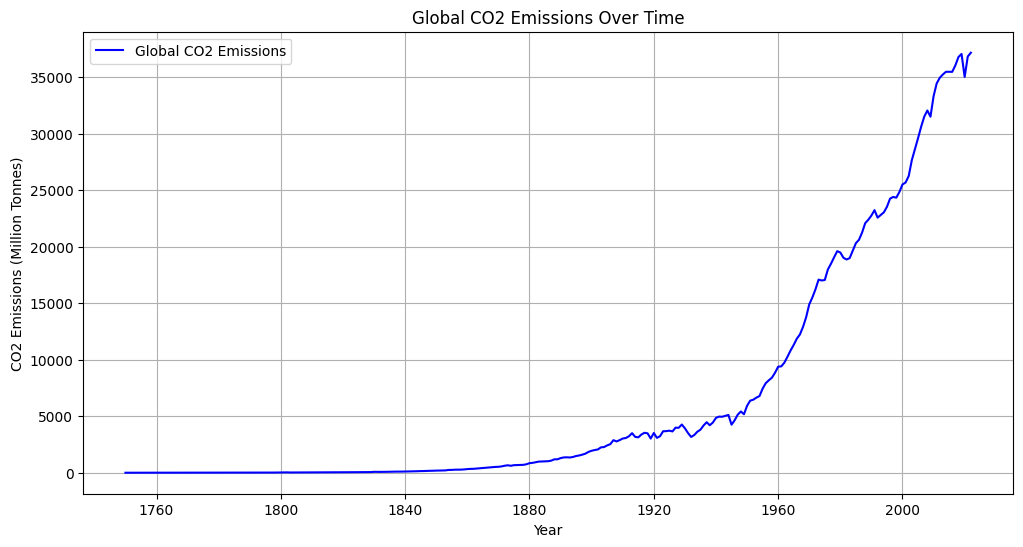

In [ ]:
# Filter data for global CO2 emissions
global_data = data[data['country'] == 'World']

# Plot Global CO2 Emissions Over Time
plt.figure(figsize=(12, 6))
plt.plot(global_data['year'], global_data['co2'], label='Global CO2 Emissions', color='blue')
plt.title('Global CO2 Emissions Over Time')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions (Million Tonnes)')
plt.legend()
plt.grid(True)
plt.show()


<ipython-input-20-1ba76d35b1db>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='co2', y='country', data=top_emitters, palette='viridis')


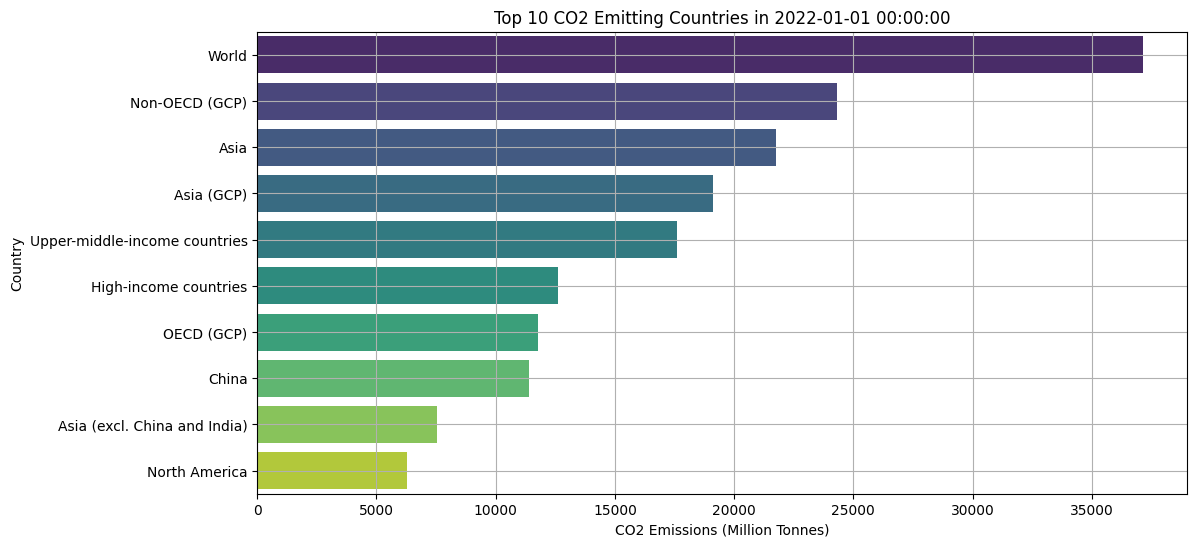

In [ ]:
# Filter the most recent year data and drop rows with missing CO2 emissions data
recent_year = data['year'].max()
recent_data = data[data['year'] == recent_year].dropna(subset=['co2'])

# Select the top 10 emitters
top_emitters = recent_data[['country', 'co2']].sort_values(by='co2', ascending=False).head(10)

# Plot the top 10 CO2 emitting countries in the most recent year
plt.figure(figsize=(12, 6))
sns.barplot(x='co2', y='country', data=top_emitters, palette='viridis')
plt.title(f'Top 10 CO2 Emitting Countries in {recent_year}')
plt.xlabel('CO2 Emissions (Million Tonnes)')
plt.ylabel('Country')
plt.grid(True)
plt.show()


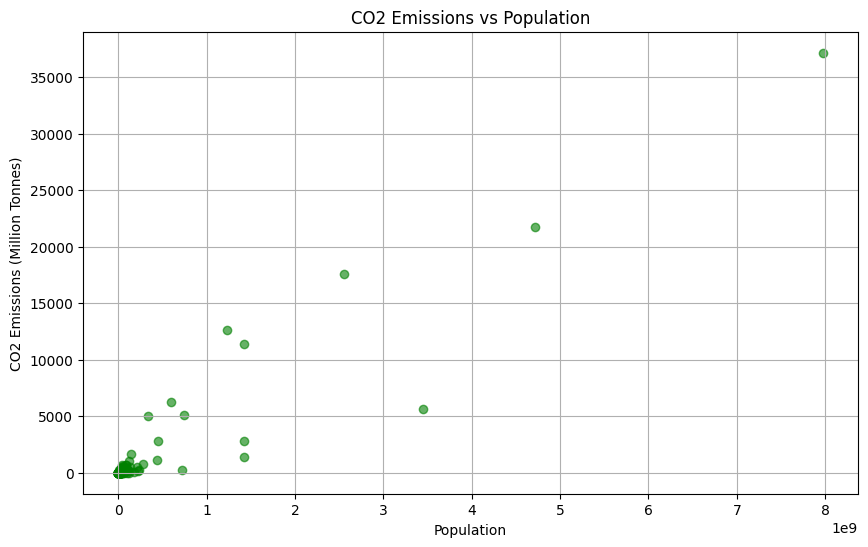

In [ ]:
# Scatter Plot for CO2 Emissions vs Population
plt.figure(figsize=(10, 6))
plt.scatter(recent_data['population'], recent_data['co2'], color='green', alpha=0.6)
plt.title('CO2 Emissions vs Population')
plt.xlabel('Population')
plt.ylabel('CO2 Emissions (Million Tonnes)')
plt.grid(True)
plt.show()


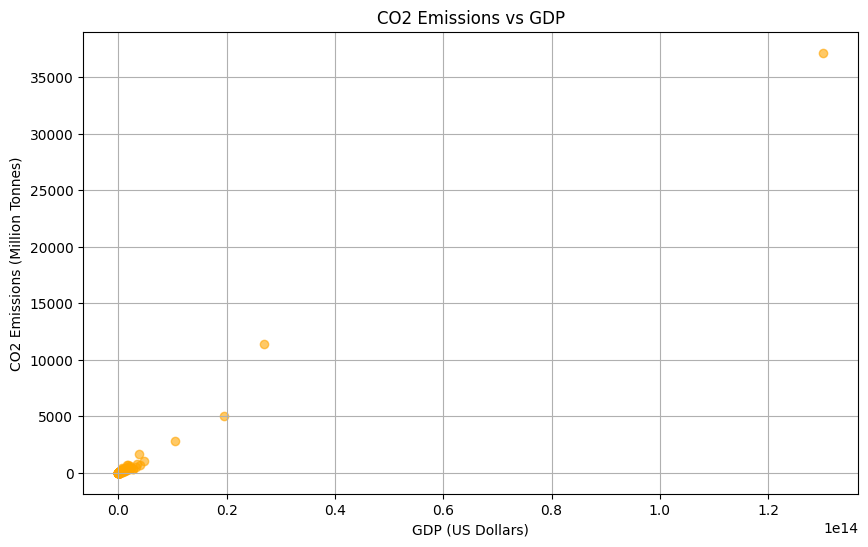

In [ ]:
# Scatter Plot for CO2 Emissions vs GDP
plt.figure(figsize=(10, 6))
plt.scatter(recent_data['gdp'], recent_data['co2'], color='orange', alpha=0.6)
plt.title('CO2 Emissions vs GDP')
plt.xlabel('GDP (US Dollars)')
plt.ylabel('CO2 Emissions (Million Tonnes)')
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Load the dataset (assuming the data is already loaded and cleaned)
# Use only 'year' and 'co2' columns from global data
global_data = data[data['country'] == 'World'][['year', 'co2']].dropna()

# Set 'year' as index
global_data.set_index('year', inplace=True)

# Prepare the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))  # Normalizing data for LSTM
scaled_data = scaler.fit_transform(global_data)

# Create dataset function for time-series data
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Define the time step for LSTM
time_step = 10
X, y = create_dataset(scaled_data, time_step)

# Reshape input to be [samples, time steps, features] as required for LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split data into training and test sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

# Create LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, batch_size=1, epochs=50)

# Predict using the test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Reshape predictions to match scaler's expectation and inverse transform
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Inverse transform actual values
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)



Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


209/209 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0033
Epoch 2/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.4503e-04
Epoch 3/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.2153e-04
Epoch 4/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.6677e-04
Epoch 5/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.8953e-05
Epoch 6/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.9267e-04
Epoch 7/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.4889e-04
Epoch 8/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.1629e-04
Epoch 9/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 9.1516e-05
Epoch 10/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2.9531e-04
Epoch 11/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.4029e-05
Epoch 12/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2316e-04
Epoch 13/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.7398e-05
Epoch 14/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2776e-04
Epoch 15/50
209/

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


209/209 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0018
Epoch 2/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.9150e-04
Epoch 3/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2317e-04
Epoch 4/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.3469e-04
Epoch 5/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.2427e-04
Epoch 6/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.2329e-04
Epoch 7/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.2238e-05
Epoch 8/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.4830e-04
Epoch 9/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.7868e-05
Epoch 10/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.9871e-05
Epoch 11/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.4366e-04
Epoch 12/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.0695e-05
Epoch 13/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.1650e-04
Epoch 14/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.6158e-04
Epoch 15/50
209/

<ipython-input-34-220fcc7718ae>:70: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  future_dates = pd.date_range(start=last_date + pd.Timedelta(days=365), periods=future_steps, freq='Y')


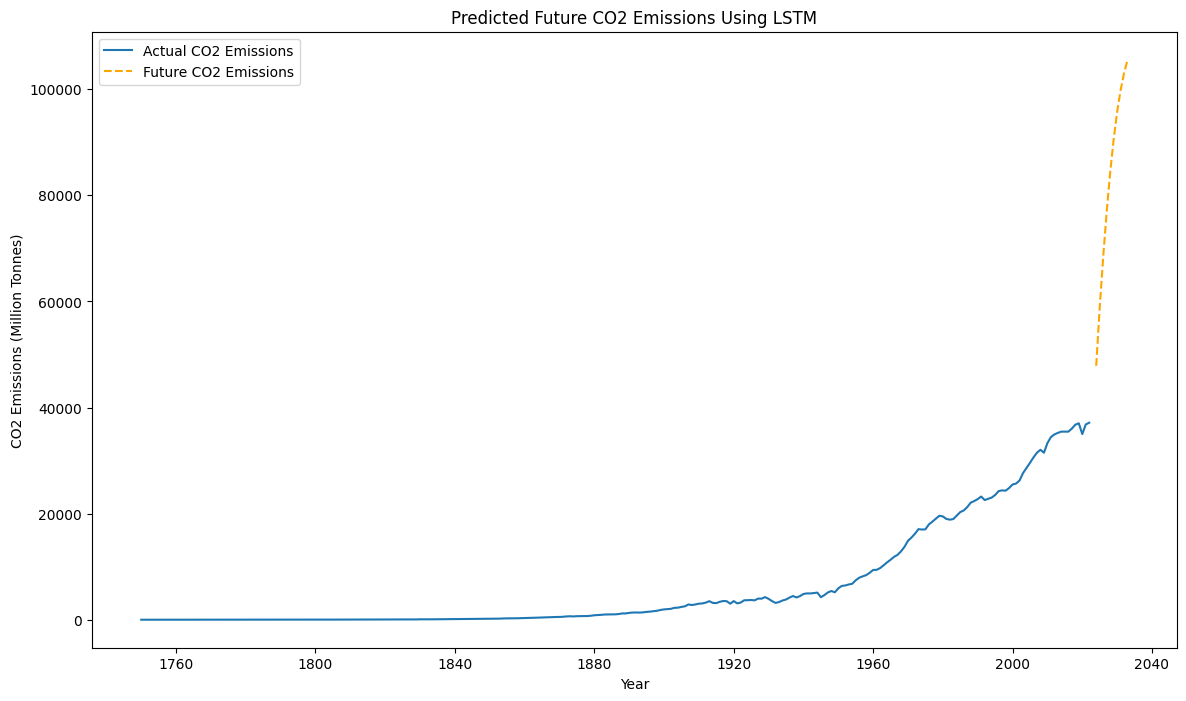

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load and prepare the dataset (assuming data is already loaded as 'data')
global_data = data[data['country'] == 'World'][['year', 'co2']].dropna()
global_data.set_index('year', inplace=True)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(global_data)

# Prepare the data for LSTM
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Create datasets
time_step = 10
X, y = create_dataset(scaled_data, time_step)

# Reshape input for LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

# Create and compile the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=50)

# Predict future CO2 emissions
# Last time step from the scaled data
last_data = scaled_data[-time_step:].reshape(1, time_step, 1)

# Number of future time steps to predict
future_steps = 10  # Change this value to predict further into the future
future_predictions = []

for _ in range(future_steps):
    # Predict the next value
    future_pred = model.predict(last_data)
    future_predictions.append(future_pred[0, 0])

    # Update the last_data to include the predicted value
    future_pred_reshaped = future_pred.reshape(1, 1, 1)  # Reshape to match the expected dimensions
    last_data = np.append(last_data[:, 1:, :], future_pred_reshaped, axis=1)

# Convert future predictions back to original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Create a date range for future predictions
last_date = global_data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=365), periods=future_steps, freq='Y')

# Prepare for plotting
future_df = pd.DataFrame(data=future_predictions, index=future_dates, columns=['Future CO2 Emissions'])

# Plot actual and predicted emissions
plt.figure(figsize=(14, 8))
plt.plot(global_data.index, scaler.inverse_transform(scaled_data), label='Actual CO2 Emissions')
plt.plot(future_df.index, future_df['Future CO2 Emissions'], label='Future CO2 Emissions', color='orange', linestyle='--')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions (Million Tonnes)')
plt.title('Predicted Future CO2 Emissions Using LSTM')
plt.legend()
plt.show()

